## **Interpretabilidad de los modelos de machine learning**

### Feature importance

**¿Qué es?**

Serie de técnicas que asignan puntuaciones a las variables independientes de un modelo predictivo en función de su importancia relativa al realizar una predicción sobre la variable dependiente o target. 

IMPORTANTE: Antes de obtener el feature importance siempre hay que evaluar la capacidad predictiva del modelo implementado.

**Tipos**

1. Métodos "built in" en modelos intrinsecamente intepretables (ya vistos al estudiar los modelos lineales y los modelos basados en árboles de decision). 

2. Permutation importance

3. Drop columns importance

4. Shap values


Para todos los ejemplos utilizaremos el dataset de Boston de Skalearn, que plantea un problema de regresión. La descripción de las variables de entrada se puede encontrar [aquí](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset)

La métrica que utilizaremos es el .score() de los modelos de regresión, es decire, el [R2 score](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
#Importamos el Boston dataset de Skalearn
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
#Construimos el dataframe para echarle un vistazo
boston_df = pd.DataFrame(boston.data,                      
                         columns=boston.feature_names)
boston_df['MEDV'] = boston.target

boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


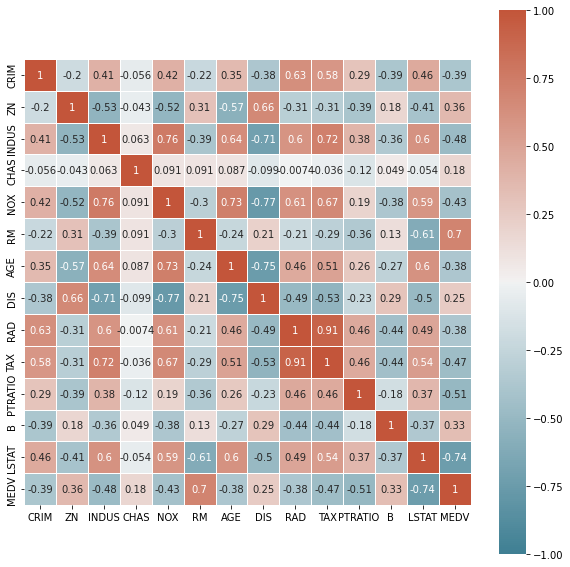

In [4]:
#Vemos que aspecto tiene la relación entre las variables 
#con una matriz de correlación
plt.figure(figsize=(10,10))

sns.heatmap(boston_df.corr(),
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
            square=True,
            annot=True,
            linewidths=.5);

In [5]:
#Espliteamos para montar el modelo
X = boston_df.drop("MEDV", axis = 1)
y = boston_df["MEDV"]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

#### Random Forest features importances 

In [6]:
#Implementamos un random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rnd_reg = RandomForestRegressor(n_estimators = 200, 
                                max_depth = 4,
                                random_state = 42)

rnd_reg.fit(X_train, y_train)

print("R2 score train",rnd_reg.score(X_train,y_train))
print("R2 score test",rnd_reg.score(X_test,y_test))

R2 score train 0.9100679528687738
R2 score test 0.8541638877397426


In [7]:
#Obtenemos el feature_importances
rnd_reg.feature_importances_

array([0.03223336, 0.00103622, 0.00296863, 0.00103821, 0.01188924,
       0.52474328, 0.00675403, 0.05143972, 0.00273076, 0.00597397,
       0.00982555, 0.00497389, 0.34439313])

In [8]:
# Transforma las feature_importances a un dataframe y ordénalas por importancia
fi_rnd= pd.DataFrame(rnd_reg.feature_importances_,
                          boston.feature_names, 
                          columns = ["Feature imp. RND"]).sort_values("Feature imp. RND", ascending=False)
fi_rnd

,Feature imp. RND
RM,0.524743
LSTAT,0.344393
DIS,0.051440
CRIM,0.032233
NOX,0.011889
PTRATIO,0.009826
AGE,0.006754
TAX,0.005974
B,0.004974
INDUS,0.002969


<AxesSubplot:>

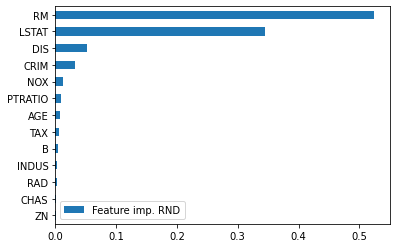

In [9]:
#Visualizamos
fi_rnd.sort_values("Feature imp. RND").plot.barh(y="Feature imp. RND")

####  Permutation importance

In [10]:
#Implementamos el permutation importance
from sklearn.inspection import permutation_importance

perm_importance_train = permutation_importance( estimator = rnd_reg,
                                                X = X_train,
                                                y = y_train,
                                                n_repeats = 10,
                                                random_state = 42,
                                                scoring='r2'
                                            
)

### CODE ####

#n_repeats = Number of times to permute a feature.

C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Obtenemos el permutation importance para cada variable, como la media del impacto de las permutaciones de sus valores sobre el rendimiento del modelo (r2) a lo largo de las repeticiones efectuadas.

In [11]:
#Raw permutation importance scores (13 features * 10 permutaciones)
perm_importance_train.importances.size
### CODE ####

130

In [12]:
# Mean of feature importance over n_repeats.
perm_importance_train.importances_mean
### CODE ####

array([3.11127430e-02, 6.74494925e-06, 1.56036859e-03, 7.92655498e-04,
       1.05330602e-02, 5.74263785e-01, 3.72704963e-03, 6.52491864e-02,
       1.38014611e-03, 4.90069175e-03, 1.64245523e-02, 2.93436345e-03,
       5.31872875e-01])

In [13]:
#Montamos el dataframe
p_imp_train = pd.DataFrame(perm_importance_train.importances_mean,
                  boston.feature_names, 
                  columns = ["Permutation importances"]).sort_values("Permutation importances", ascending = False)
p_imp_train
### CODE ####

,Permutation importances
RM,0.574264
LSTAT,0.531873
DIS,0.065249
CRIM,0.031113
PTRATIO,0.016425
NOX,0.010533
TAX,0.004901
AGE,0.003727
B,0.002934
INDUS,0.001560


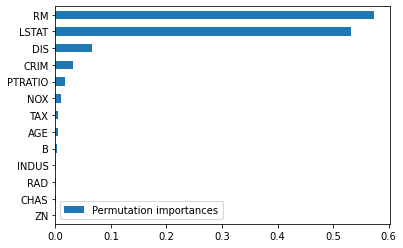

In [14]:
### CODE ####
p_imp_train.sort_values("Permutation importances").plot.barh(y='Permutation importances');

In [15]:
#Obtenemos el permutation importance sobre los datos dde test

perm_importance_test = permutation_importance(
    estimator = rnd_reg, 
    X = X_test, 
    y = y_test,
    n_repeats=10,
    random_state=42,
    scoring = "r2")

In [16]:
# Lo pasamos a un DataFrame
p_imp_test = pd.DataFrame(perm_importance_test.importances_mean,
                  boston.feature_names, 
                  columns = ["Permutation importances"]).sort_values("Permutation importances", ascending = False)
p_imp_test

,Permutation importances
LSTAT,0.542102
RM,0.460911
DIS,0.077298
CRIM,0.031606
PTRATIO,0.020151
NOX,0.018016
TAX,0.003033
B,0.001460
INDUS,0.001260
RAD,0.000880


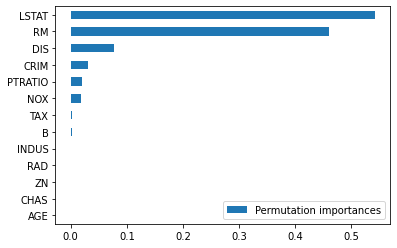

In [17]:
#Graficamos
p_imp_test.sort_values("Permutation importances").plot.barh(y= "Permutation importances");

### Drop columns

In [18]:
# Primero vemos como se haría manualmente
from sklearn.base import clone 


# Create un unfitted model with the exact same specification as the one initially trained
model_clone = clone(rnd_reg)
# set random_state for comparability
model_clone.random_state = 42
# training and scoring the benchmark model
model_clone.fit(X_train, y_train)
baseline_score = model_clone.score(X_train, y_train)
# list for storing feature importances
importances = []
    
# iterating over all columns and storing feature importance (difference between benchmark and new model)
for col in X_train.columns:
    model_clone = clone(rnd_reg)
    model_clone.random_state = 42
    model_clone.fit(X_train.drop(col , axis=1), y_train)
    drop_col_score = model_clone.score(X_train.drop(col , axis=1), y_train)
    importances.append(baseline_score - drop_col_score)

In [19]:
# Lo pasamos a dataframe
drop_col_manual = pd.DataFrame(importances, 
                              X_train.columns, 
                              columns = ["Drop columns importance"]).sort_values("Drop columns importance", ascending = False)
drop_col_manual

,Drop columns importance
LSTAT,0.048145
RM,0.031670
DIS,0.011000
PTRATIO,0.002284
NOX,0.001165
TAX,0.000789
CRIM,0.000655
B,0.000504
AGE,0.000479
INDUS,0.000135


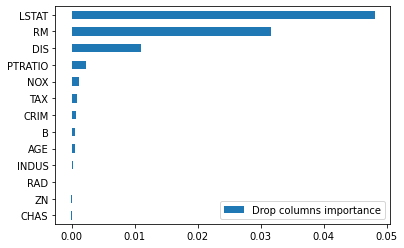

In [20]:
#Graficamos
drop_col_manual.sort_values("Drop columns importance").plot.barh(y= "Drop columns importance");

#### Drop columns con la librería rfpimp

A clone of model is trained once to get the baseline score and then
again, once per feature to compute the drop in either the model's .score() output or a custom metric callable in the form of metric(model, X_valid, y_valid).In case of a custom metric the X_valid and y_valid parameters should be set.

[Ver documentación rfpimp](https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py)

In [22]:
#Utilizamos la librería rfpimp, que tiene un método para esto

#pip install rfpimp
from rfpimp import dropcol_importances
### CODE ####

drop_col = dropcol_importances(rnd_reg, X_train, y_train)
drop_col
#La metrica que utiliza por defecto es el .score del modelo, en este caso
#el R2 al ser un problema de regresión.

,Importance
Feature,
LSTAT,0.051368
RM,0.034901
DIS,0.011371
PTRATIO,0.001894
NOX,0.001447
CRIM,0.001070
TAX,0.000732
B,0.000690
AGE,0.000488


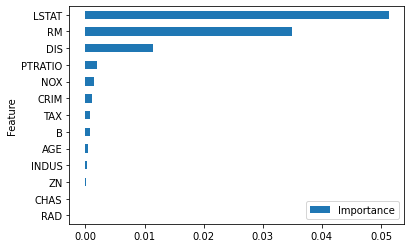

In [24]:
# Graficamos
drop_col.sort_values("Importance").plot.barh(y= "Importance");